In [1]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def readSensorData(clientId=-1, 
                    range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    returnCodeRanges, string_range_data = sim.simxGetStringSignal(clientId, range_data_signal_id, sim.simx_opmode_streaming)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    returnCodeAngles, string_angle_data = sim.simxGetStringSignal(clientId, angle_data_signal_id, sim.simx_opmode_blocking)

    # check the if both data were obtained correctly
    if returnCodeRanges == 0 and returnCodeAngles == 0:
        # unpack data from range and sensor messages
        raw_range_data = sim.simxUnpackFloats(string_range_data)
        raw_angle_data = sim.simxUnpackFloats(string_angle_data)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None

In [13]:
def Rz(theta):
  
    return np.array([[  np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta),  np.cos(theta), 0 ],
                      [ 0            ,  0            , 1 ]])

In [26]:
def occupancy_grid():
    pass

In [34]:
print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    map_size = np.array([20, 20])
    cell_size = 1
    rows, cols = (map_size/cell_size).astype(int)
    
    robotname = 'kobuki'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    
    returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait) 
        
    returnCode, l_wheel = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, r_wheel = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)    
    
    # Handles para os sonares
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"
    
    returnCode = 1
    while returnCode != 0:
        returnCode, range_data = sim.simxGetStringSignal(clientID, laser_range_data, sim.simx_opmode_streaming + 10)
       
    # Específico do robô   
    L = 0.230
    r = 0.035
    
    v = 0
    w = np.deg2rad(0)   
           
    # Mapa inicial.
    m = np.ones((rows, cols)) / 2
    
    # Marca como ocupado a posição inicial do robô.
    m[0,0] = 1 
    
    caminho, obs = [], []
    # rng = np.random.default_rng()
    # rng.random((rows, cols))
    
    t = 0
    # Lembrar de habilitar o 'Real-time mode'
    startTime=time.time()
    lastTime = startTime
    while t < 10:
        
        now = time.time()
        dt = now - lastTime
        
        returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        returnCode, orientacao = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        
        raw_range_data, raw_angle_data = readSensorData(clientID, laser_range_data, laser_angle_data)
        laser_data = np.array([raw_angle_data, raw_range_data]).T
        
        DIRECOES = {"frente": int(len(laser_data)/2), 
                    "direita": int(len(laser_data)*1/4),
                    "esquerda": int(len(laser_data)*3/4)}
        
        dist_obstaculos = np.array([laser_data[DIRECOES[d], 1] for d in DIRECOES])
        
        # Posição dos 'obstáculos' (posições onde o sensor leu) em relação ao robô.
        pos_obstaculos = [pos + dist_obstaculo for dist_obstaculo in dist_obstaculos]
        
        # Gera as matrizes de transformação homogênea para converter da posição de um 'obstaculo' no referêncial do robô, para o referêncial global.
        for pos_obstaculo in pos_obstaculos:
            T = np.column_stack((Rz(orientacao[0]), pos_obstaculo))
            aux = np.array([0, 0, 0, 1])
            T = np.row_stack((T, aux))
        
        # Descobre a posição do 'obstáculo' em relação ao referêncial global.
        pos_obstaculos_W = []
        for pos_obstaculo in pos_obstaculos:
            pos_obstaculos_W.append(T @ [pos_obstaculo, 1])
        
        if laser_data[DIRECOES["frente"], 1] > 2:
            v = .3
            w = 0
        elif laser_data[DIRECOES["direita"], 1] > 2:
            v = 0
            w = np.deg2rad(-30)
        elif laser_data[DIRECOES["esquerda"], 1] > 2:
            v = 0
            w = np.deg2rad(30)
        
        #Modelo Cinemático
        wl = v/r - (w*L)/(2*r)
        wr = v/r + (w*L)/(2*r)

        # Enviando velocidades
        sim.simxSetJointTargetVelocity(clientID, l_wheel, wl, sim.simx_opmode_oneshot_wait)
        sim.simxSetJointTargetVelocity(clientID, r_wheel, wr, sim.simx_opmode_oneshot_wait)
        
        t = t + dt        
        lastTime = now
       
    sim.simxSetJointTargetVelocity(clientID, r_wheel, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, l_wheel, 0, sim.simx_opmode_oneshot_wait)
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

Program started
Connected to remote API server


/tmp/ipykernel_38106/350139432.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pos_obstaculos_W.append(T @ [pos_obstaculo, 1])


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)

NameError: name 'm' is not defined

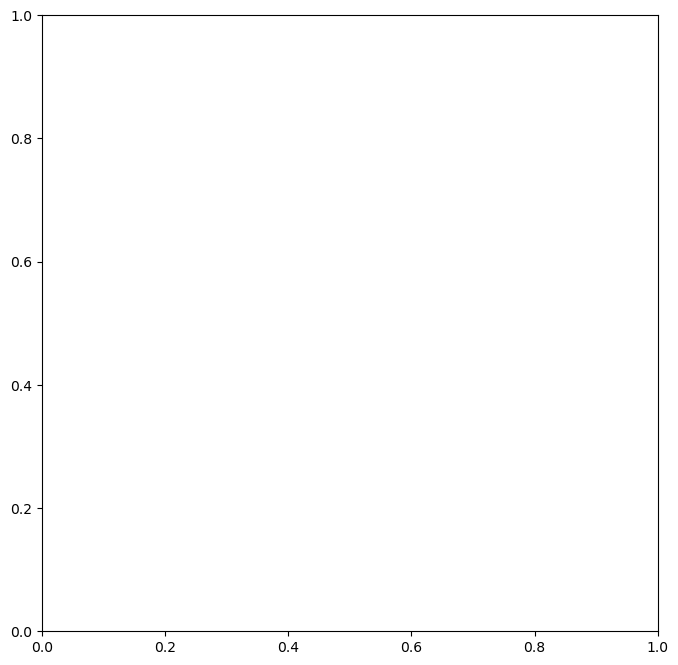

In [4]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')


plt.imshow(m, cmap='Greys', origin='upper', extent=(0, cols, rows, 0))

ax.set_xticks(np.arange(0, cols, cell_size))
ax.set_yticks(np.arange(0, rows, cell_size))

plt.colorbar()